# Data Cleaning for Regression Models, RFM and ABC analysis on Data Co Supply Chain Data

We will be performing RFM and ABC analysis on the Data Co Supply Chain Dataset. Recency, Frequency, And Monetary Analysis(RFM) and ABC are techniques in which we analyze historical data to give us an idea about important factors in our business and how we can better manage future running of business.

Recency Frequency Monetary analysis helps demand side sector of an organization by segmenting customers and providing more insights to marketing department and sales department about the customers who buy products at the store.

ABC analysis helps the supply side sector of an organization by segmenting products based on revenue they generate. It helps manage inventory more efficiently.

We will also be performing some data cleaning so that if we wanted to use that data in regression, we could use it. 

## Needed Packages

In [1]:
import pandas as pd
import dateutil.parser
import numpy as np
import datetime
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns;
import matplotlib.pyplot as plt
from plotly import graph_objects as go
import plotly.express as px

In [2]:
dFppsc= pd.read_csv("../input/dataco-smart-supply-chain-for-big-data-analysis/DataCoSupplyChainDataset.csv", encoding_errors="ignore")
dFppsc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

We have added description of various columns in "DescriptionDataCoSupplyChain.xlsx" file. This will give you context of various datapoints present in the dataframe.

## Data Cleaning for Regression Models

**Looking for Missing values or null values.**

From the above information we can see that "Customer Zipcode" is null at 3 places and "Order Zipcode" is null at 155679 places. 
But they are not so important when we have features Order State, Order Region, Order City, Order Country, Latitude, Langitude, Customer Street, Customer City, Customer State. 

Product Description is null for all the records and we will drop that column going forward.

Customer LName is also null at 8 places. Again it will not matter much as we will be using Customer Id to identify all the purchases a particular customer has made at a store.

All other columns are have 0 null values.

In [3]:
dFppsc.drop("Product Description",axis=1,inplace=True)

**Converting Date Columns to datetime objects**

In [4]:
dFppsc["order date (DateOrders)"]=pd.to_datetime(dFppsc["order date (DateOrders)"])
dFppsc["shipping date (DateOrders)"]=pd.to_datetime(dFppsc["shipping date (DateOrders)"])
dFppsc=dFppsc.sort_values(by="order date (DateOrders)")

**Identifying duplicate columns with help of co-relation function.** 

After seeing the context of the columns in the attached description file it seems that many of the columns are having the same data. We will use co-relation to identify them.

In [5]:
m=dFppsc.corr()
m[m==1].to_excel("corr1.xlsx")
matrix=m.abs()
upper_tri = matrix.where(np.triu(np.ones(matrix.shape),k=1).astype(bool))
co_col=[column for column in upper_tri.columns if any(upper_tri[column] ==1)]
co_linear_col=[]
for c in co_col:
    co_linear_col.append([c,matrix[c][matrix[c]==1]])
co_linear_col  
for c in co_linear_col:
    print(c[1])

Customer Id          1.0
Order Customer Id    1.0
Name: Order Customer Id, dtype: float64
Sales per customer    1.0
Order Item Total      1.0
Name: Order Item Total, dtype: float64
Benefit per order         1.0
Order Profit Per Order    1.0
Name: Order Profit Per Order, dtype: float64
Order Item Cardprod Id    1.0
Product Card Id           1.0
Name: Product Card Id, dtype: float64
Category Id            1.0
Product Category Id    1.0
Name: Product Category Id, dtype: float64
Order Item Product Price    1.0
Product Price               1.0
Name: Product Price, dtype: float64


We calculated the corelation between different columns and found out that several columns have correlation of 1. This is not possible unless they are duplicate columns or one columns is derived from another for e.g x=5y.

In [6]:
print("Length of the data frame where benefits per order and order profit per order are not equal :"+str(dFppsc[dFppsc["Benefit per order"]!=dFppsc["Order Profit Per Order"]].shape[0]))
print("Length of the data frame where sales per customer and Order Item Total are not equal :"+str(dFppsc[dFppsc["Sales per customer"]!=dFppsc["Order Item Total"]].shape[0]))
print("Length of the data frame where Order Item Cardprod Id and Product Card Id are not equal :"+str(dFppsc[dFppsc["Order Item Cardprod Id"]!=dFppsc["Product Card Id"]].shape[0]))
print("Length of the data frame where Product Price and Order Item Product Price are not equal :"+str(dFppsc[dFppsc["Product Price"]!=dFppsc["Order Item Product Price"]].shape[0]))
print("Length of the data frame where Category Id and Product Category Id are not equal :"+str(dFppsc[dFppsc["Product Category Id"]!=dFppsc["Category Id"]].shape[0]))
print("Length of the data frame where Order Customer Id and Customer Id Product Price are not equal :"+str(dFppsc[dFppsc["Order Customer Id"]!=dFppsc["Customer Id"]].shape[0]))

Length of the data frame where benefits per order and order profit per order are not equal :0
Length of the data frame where sales per customer and Order Item Total are not equal :0
Length of the data frame where Order Item Cardprod Id and Product Card Id are not equal :0
Length of the data frame where Product Price and Order Item Product Price are not equal :0
Length of the data frame where Category Id and Product Category Id are not equal :0
Length of the data frame where Order Customer Id and Customer Id Product Price are not equal :0


After comparing the values in columns pairs having co-relation of 1, we can see that all values are equal for these pair of columns. We can drop one of the columns from each of the above pairs as they are duplicate columns of each other.

In [7]:
dFppsc.drop(["Benefit per order","Sales per customer","Order Item Cardprod Id","Order Item Product Price","Product Category Id","Order Customer Id"],axis=1,inplace=True)

**Using Variance Inflation Factor to find out multi-colinearity between three or more columns**

Corelation helps us in finding relations between any two columns. But what if we want to find out if there is a relation between three or more columns. That's where Variance Inflaction Factor can help.

**Variance Inflation Factor (VIF)** - VIF is the ratio of variance of coefficient estimate when fitting the full model divided by the variance of coefficient estimate if fit on its own. The minimum possible value is 1 which indicates no collinearity. If value exceeds 5, then collinearity should be addressed.

We will take all the numeric columns and try to find variance_inflation_factor for them.

In [8]:
vif=pd.DataFrame()
vif["columns"]=['Order Item Discount',
       'Order Item Discount Rate', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order','Product Price']
vif["vif value"] = [variance_inflation_factor(dFppsc[['Order Item Discount',
       'Order Item Discount Rate', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order','Product Price']].values, i) for i in range(len(vif["columns"]))]
vif.T

,0,1,2,3,4,5,6,7
columns,Order Item Discount,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Product Price
vif value,389415821.949077,6.126471,3.410618,12.809224,25472272275.347256,20690128715.483124,3.413,24.873511


You can see that several of columns have vif values above 5 and some of them are very high. Such high value usually indicate that value in one column can be derived from values in other columns. Lets look at the data and see if we can find the relation.

In [9]:
dFppsc[['Order Item Discount',
       'Order Item Discount Rate', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order','Product Price']].head(5)

,Order Item Discount,Order Item Discount Rate,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Product Price
33833,60.00,0.20,0.37,1,299.980011,239.979996,88.790001,299.980011
77011,6.00,0.03,0.47,1,199.990005,193.990005,91.180000,199.990005
109322,22.50,0.09,0.30,5,250.000000,227.500000,68.250000,50.000000
87884,22.10,0.17,0.34,1,129.990005,107.889999,36.470001,129.990005
114915,39.98,0.20,0.21,4,199.919998,159.940002,33.590000,49.980000


When you do some basic math you will find these below relationship among these columns:-
1. Sales = Product Price * Order Item Quantity
2. Order Item Total = Sales - Order Item Discount 
3. Order Item Discount = Sales * Order Item Discount Rate
4. Order Profit Per Order= Order Item Total * Order Item Profit Ratio

These are perfect multi colinear features that shouldn't be passed on to regression models because it affects the performance of the model. You can drop one of the features from each of the above relationship.

In [10]:
df1=dFppsc.drop(["Order Item Total","Product Price","Order Item Discount Rate","Order Profit Per Order"],axis=1)

In [11]:
vif=pd.DataFrame()
vif["columns"]=['Sales',
                'Order Item Quantity','Order Item Discount','Order Item Profit Ratio']
vif["data"] = [variance_inflation_factor(df1[['Sales',
                'Order Item Quantity','Order Item Discount','Order Item Profit Ratio']].values, i) for i in range(len(vif["columns"]))]
vif

,columns,data
0,Sales,4.200158
1,Order Item Quantity,2.124456
2,Order Item Discount,3.068174
3,Order Item Profit Ratio,1.052867


**As you can see the vif value greatly reduced after we dropped the columns. These are some ways to clean the data before you use it for regression**

**Now lets do some data cleaning for performing RFM and ABC analysis. Lets look at the different Delivery Statuses**

In [12]:
dFppsc["Delivery Status"].unique()

array(['Advance shipping', 'Late delivery', 'Shipping on time',
       'Shipping canceled'], dtype=object)

In [13]:
dFppsc.groupby("Delivery Status")["Order Id"].count()

Delivery Status
Advance shipping     41592
Late delivery        98977
Shipping canceled     7754
Shipping on time     32196
Name: Order Id, dtype: int64

We can see that there are 7754 orders where shipping has been canceled. Lets try to find why it may be happening.

In [14]:
dFppsc[dFppsc["Delivery Status"]=="Shipping canceled"].groupby("Order Status").agg(tc=("Order Id","count"))

,tc
Order Status,
CANCELED,3692
SUSPECTED_FRAUD,4062


As you can see shipping has been canceled because customer canceled his order or order was marked as suspected fraud. We will have to remove these orders when we do RFM and ABC analysis as these were transaction that didn't add any value for store or for customer.

In [15]:
dF_clean=dFppsc[dFppsc["Delivery Status"]!="Shipping canceled"].copy()

## Recency Frequency Monetary(RFM) Analysis 

RFM analysis is a way to segment customers. This segmentation helps us to identify our most valuable customer. But what does Recency Frequency And Monetary mean?

- **Recency** - How Recently has the customer purchased from us? Ideally the difference between the customer last purchase date and todays date.

- **Frequency** - Total number of purchases made from our store or average time between two purchases at the store.

- **Monetary** - Total value of all purchases made by the customer.

The more recent the purchase, more responsive the customer is to promotions
The more frequently the customer buys, the more engaged and satisfied the customer are.
The monetary values helps us to distinguish between big spenders and low spenders.

RFM analysis is one of the most common techniques used for customer segmentation and is used for making targeted promotions by marketing deparment. Lets begin the process of RFM analysis.

#### Frequency

We will find the total number of unique orders that each Customer Id have placed with us.

In [16]:
dF_frequency=dF_clean.groupby(["Customer Id"]).agg(Total_count=("Order Id","nunique"))
dF_frequency

,Total_count
Customer Id,
1,1
2,4
3,5
4,4
5,3
...,...
20753,1
20754,1
20755,1


In [17]:
dF_frequency.to_excel("Frequency.xlsx")

When we see the excel file we observe one thing that after customer Id 12434, no new customer have made any repeat purchase. We must find out if this is normal or there is some issue here. We will see if these customer id's are purchasing in particular time period or happening in all the years.

In [18]:
dF_clean["Year"]=dF_clean["order date (DateOrders)"].dt.year
dF_frequency_year=dF_clean.groupby(["Customer Id","Year"],as_index=False)["Order Id"].nunique()
dF_frequency_year

,Customer Id,Year,Order Id
0,1,2015,1
1,2,2015,1
2,2,2016,1
3,2,2017,2
4,3,2015,1
...,...,...,...
36748,20753,2018,1
36749,20754,2018,1
36750,20755,2018,1
36751,20756,2018,1


Lets Organize this data in a organized way so it will be easy for us to compare.

In [19]:
dF_frequency_year=dF_frequency_year.pivot_table(index="Customer Id",columns="Year",values="Order Id",fill_value=0)
dF_frequency_year

Year,2015,2016,2017,2018
Customer Id,,,,
1,1,0,0,0
2,1,1,2,0
3,1,1,3,0
4,2,1,1,0
5,0,3,0,0
...,...,...,...,...
20753,0,0,0,1
20754,0,0,0,1
20755,0,0,0,1


In [20]:
dF_frequency_year.to_excel("frequency_year.xlsx")

We find something odd in this excel file. No customer having Customer Id less than 12436 has purchased in 2018. Also after customer id 12436, all the customer have made puchase exactly once in the current year at that point of time.

Lets dive further into data to figure out the issue.

In [21]:
pd.set_option("display.max_columns",None)
dF_clean[dF_clean["Customer Id"]==12436]

,Type,Days for shipping (real),Days for shipment (scheduled),Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode,Year
33457,CASH,5,4,Late delivery,1,59,Books,Brownsville,EE. UU.,XXXXXXXXX,Mike,12436,Gulvishvokov,XXXXXXXXX,Consumer,TX,6303 Heather Plaza,78521.0,8,Book Shop,25.961628,-97.577255,Europe,Trieste,Italia,2017-10-02 12:46:00,68884,5.59,0.18,172199,0.09,1,31.08,25.49,2.24,Southern Europe,Friuli-Venecia Julia,CLOSED,NaN,1346,http://images.acmesports.sports/Sports+Books,Sports Books,31.08,0,2017-10-07 12:46:00,Standard Class,2017


This particular customer has purchased at 2017-10-02 12:46:00. Lets see the data around this timestamp to see if we can find something unusual.

In [22]:
dt1=datetime.datetime.strptime('02-10-2017 12:46:00', '%d-%m-%Y %H:%M:%S')
dt2=dt1-datetime.timedelta(days=5)

In [23]:
df_exploring=dF_clean[dF_clean["order date (DateOrders)"]>=dt2]
df_exploring.to_excel("afterdt1.xlsx")
df_exploring[df_exploring["order date (DateOrders)"]>=dt1]

,Type,Days for shipping (real),Days for shipment (scheduled),Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode,Year
33457,CASH,5,4,Late delivery,1,59,Books,Brownsville,EE. UU.,XXXXXXXXX,Mike,12436,Gulvishvokov,XXXXXXXXX,Consumer,TX,6303 Heather Plaza,78521.0,8,Book Shop,25.961628,-97.577255,Europe,Trieste,Italia,2017-10-02 12:46:00,68884,5.590000,0.18,172199,0.09,1,31.080000,25.490000,2.240000,Southern Europe,Friuli-Venecia Julia,CLOSED,NaN,1346,http://images.acmesports.sports/Sports+Books,Sports Books,31.080000,0,2017-10-07 12:46:00,Standard Class,2017
36638,PAYMENT,6,2,Late delivery,1,59,Books,Brownsville,EE. UU.,XXXXXXXXX,Anne,12437,Patel,XXXXXXXXX,Consumer,TX,6303 Heather Plaza,78521.0,8,Book Shop,25.961628,-97.577255,Europe,Aix-les-Bains,Francia,2017-10-02 13:08:00,68885,5.280000,0.17,172200,0.08,1,31.080000,25.799999,1.930000,Western Europe,Auvernia-Rdano-Alpes,PENDING_PAYMENT,NaN,1346,http://images.acmesports.sports/Sports+Books,Sports Books,31.080000,0,2017-10-08 13:08:00,Second Class,2017
48521,DEBIT,2,2,Shipping on time,0,59,Books,Littleton,EE. UU.,XXXXXXXXX,Filipe,12438,Godinho,XXXXXXXXX,Corporate,CO,9526 Noble Embers Ridge,80126.0,8,Book Shop,39.522995,-104.948219,Europe,Viena,Austria,2017-10-02 13:29:00,68886,4.970000,0.16,172201,0.23,1,31.080000,26.110001,5.870000,Western Europe,Viena,COMPLETE,NaN,1346,http://images.acmesports.sports/Sports+Books,Sports Books,31.080000,0,2017-10-04 13:29:00,Second Class,2017
24764,DEBIT,2,1,Late delivery,1,59,Books,San Marcos,EE. UU.,XXXXXXXXX,Joanha,12440,Mirkckociv,XXXXXXXXX,Corporate,CA,8324 Little Common,92069.0,8,Book Shop,33.146751,-117.169533,Europe,Forst,Alemania,2017-10-02 13:50:00,68887,4.660000,0.15,172202,0.08,1,31.080000,26.420000,1.980000,Western Europe,Brandenburgo,COMPLETE,NaN,1346,http://images.acmesports.sports/Sports+Books,Sports Books,31.080000,0,2017-10-04 13:50:00,First Class,2017
39318,DEBIT,4,2,Late delivery,1,59,Books,Caguas,Puerto Rico,XXXXXXXXX,John,12441,Gerginokish,XXXXXXXXX,Corporate,PR,10 Crystal River Mall,725.0,8,Book Shop,18.231728,-66.370628,Europe,Le Mans,Francia,2017-10-02 14:11:00,68888,4.040000,0.13,172203,0.47,1,31.080000,27.040001,12.710000,Western Europe,Pases del Loira,COMPLETE,NaN,1346,http://images.acmesports.sports/Sports+Books,Sports Books,31.080000,0,2017-10-06 14:11:00,Second Class,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160537,TRANSFER,6,4,Late delivery,1,76,Women's Clothing,Caguas,Puerto Rico,XXXXXXXXX,Chava,20753,Velez,XXXXXXXXX,Consumer,PR,9861 Grand Elk Trace,725.0,4,Apparel,18.273024,-66.037056,Pacific Asia,Bekasi,Indonesia,2018-01-31 22:14:00,77200,53.959999,0.25,180515,-0.67,1,215.820007,161.869995,-107.959999,Southeast Asia,Java Occidental,PROCESSING,NaN,1363,http://images.acmesports.sports/Summer+dresses,Summer dresses,215.820007,0,2018-02-06 22:14:00,Standard Class,2018
93905,DEBIT,2,4,Advance shipping,0,76,Women's Clothing,Plainfield,EE. UU.,XXXXXXXXX,Stacey,20754,Weber,XXXXXXXXX,Consumer,IL,5919 Hidden Anchor Port,60544.0,4,Apparel,41.608639,-88.202042,Pacific Asia,Bekasi,Indonesia,2018-01-31 22:35:00,77201,43.160000,0.20,180516,-0.73,1,215.820007,172.660004,-126.559998,Southeast Asia,Java Occidental,COMPLETE,NaN,1363,http://images.acmesports.sports/Summer+dresses,Su

As we can see after date time of "02-10-2017 12:46:00" all the customer that are recorded in system are new. There are no records of old customer purchasing after **2nd October 2017 12:46 PM.** This may be due to multiple reasons and in real life we must connect with the data engineers or the data owners to know the reason behind this irregularity.

One possible reason could be that after the above date time the company started using different system to handle old customers and was using the same system to handle new customers

We can try to see that if there are records with same Customer Name and Customer City after the above timestamp and before the timestamp. If there are such cases present, we can compare their other transaction details such as product purchased ,customer street, Order city to find out whether these customers are the same and system have erroneously assigned a new customer Id even to old customer

In [24]:
dF_clean["Customer Full Name"]=dF_clean["Customer Fname"]+" "+dF_clean["Customer Lname"]
datetime_val = datetime.datetime.strptime('02-10-2017 12:46:00', '%d-%m-%Y %H:%M:%S')
Customer_Names_After_Dt=dF_clean[dF_clean["order date (DateOrders)"]>=datetime_val][["Customer Full Name","Customer City"]].drop_duplicates()

In [25]:
Customer_Name_Common_Before_After_dt=pd.merge(dF_clean[(dF_clean["order date (DateOrders)"]<=datetime_val)],Customer_Names_After_Dt,how="inner",on=["Customer Full Name","Customer City"])
Records=pd.merge(Customer_Name_Common_Before_After_dt[["Customer Full Name","Customer City"]].drop_duplicates(),dF_clean,how="inner",on=["Customer Full Name","Customer City"])
Records.to_excel("idissue.xlsx")

In [26]:
Records[Records["Customer Full Name"]=="Jennifer Ramos"]

,Customer Full Name,Customer City,Type,Days for shipping (real),Days for shipment (scheduled),Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer Country,Customer Email,Customer Fname,Customer Id,Customer Lname,Customer Password,Customer Segment,Customer State,Customer Street,Customer Zipcode,Department Id,Department Name,Latitude,Longitude,Market,Order City,Order Country,order date (DateOrders),Order Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order State,Order Status,Order Zipcode,Product Card Id,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode,Year
0,Jennifer Ramos,Caguas,DEBIT,4,2,Late delivery,1,29,Shop By Sport,Puerto Rico,XXXXXXXXX,Jennifer,11466,Ramos,XXXXXXXXX,Consumer,PR,8615 Velvet River Knoll,725.0,5,Golf,18.212088,-66.370499,LATAM,Santa Clara,Cuba,2015-01-05 02:47:00,283,21.59,0.18,706,0.29,3,119.970001,98.379997,28.530001,Caribbean,Villa Clara,COMPLETE,NaN,627,http://images.acmesports.sports/Under+Armour+G...,Under Armour Girls' Toddler Spine Surge Runni,39.990002,0,2015-01-09 02:47:00,Second Class,2015
1,Jennifer Ramos,Caguas,DEBIT,4,2,Late delivery,1,46,Indoor/Outdoor Games,Puerto Rico,XXXXXXXXX,Jennifer,11466,Ramos,XXXXXXXXX,Consumer,PR,8615 Velvet River Knoll,725.0,7,Fan Shop,18.212088,-66.370499,LATAM,Santa Clara,Cuba,2015-01-05 02:47:00,283,12.50,0.25,708,-0.73,1,49.980000,37.490002,-27.480000,Caribbean,Villa Clara,COMPLETE,NaN,1014,http://images.acmesports.sports/O%27Brien+Men%...,O'Brien Men's Neoprene Life Vest,49.980000,0,2015-01-09 02:47:00,Second Class,2015
2,Jennifer Ramos,Caguas,DEBIT,4,2,Late delivery,1,48,Water Sports,Puerto Rico,XXXXXXXXX,Jennifer,11466,Ramos,XXXXXXXXX,Consumer,PR,8615 Velvet River Knoll,725.0,7,Fan Shop,18.212088,-66.370499,LATAM,Santa Clara,Cuba,2015-01-05 02:47:00,283,4.00,0.02,709,-0.70,1,199.990005,195.990005,-137.190002,Caribbean,Villa Clara,COMPLETE,NaN,1073,http://images.acmesports.sports/Pelican+Sunstr...,Pelican Sunstream 100 Kayak,199.990005,0,2015-01-09 02:47:00,Second Class,2015
3,Jennifer Ramos,Caguas,DEBIT,4,2,Late delivery,1,46,Indoor/Outdoor Games,Puerto Rico,XXXXXXXXX,Jennifer,11466,Ramos,XXXXXXXXX,Consumer,PR,8615 Velvet River Knoll,725.0,7,Fan Shop,18.212088,-66.370499,LATAM,Santa Clara,Cuba,2015-01-05 02:47:00,283,2.00,0.01,707,0.26,4,199.919998,197.919998,51.459999,Caribbean,Villa Clara,COMPLETE,NaN,1014,http://images.acmesports.sports/O%27Brien+Men%...,O'Brien Men's Neoprene Life Vest,49.980000,0,2015-01-09 02:47:00,Second Class,2015
4,Jennifer Ramos,Caguas,DEBIT,2,2,Shipping on time,0,24,Women's Apparel,Puerto Rico,XXXXXXXXX,Jennifer,11466,Ramos,XXXXXXXXX,Consumer,PR,8615 Velvet River Knoll,725.0,5,Golf,18.212088,-66.370499,Europe,Barcelona,Espaa,2015-06-14 05:22:00,11251,18.00,0.09,28114,0.34,4,200.000000,182.000000,61.520000,Southern Europe,Catalua,COMPLETE,NaN,502,http://images.acmesports.sports/Nike+Men%27s+D...,Nike Men's Dri-FIT Victory Golf Polo,50.000000,0,2015-06-16 05:22:00,Second Class,2015
5,Jennifer Ramos,Caguas,DEBIT,2,2,Shipping on time,0,45,Fishing,Puerto Rico,XXXXXXXXX,Jennifer,11466,Ramos,XXXXXXXXX,Consumer,PR,8615 Velvet River Knoll,725.0,7,Fan Shop,18.212088,-66.370499,Europe,Barcelona,Espaa,2015-06-14 05:22:00,11251,8.00,0.02,28116,0.00,1,399.980011,391.980011,0.000000,Southern Europe,Catalua,COMPLETE,NaN,1004,http://images.acmesports.sports/Field+%26+Stre...,Field & Stream Sportsman 16 Gun Fire Safe,399.980011,0,2015-06-16 05:22:00,Second Class,2015
6,Jennifer Ramos,Caguas,DEBIT,2,2,Shipping on time,0,29,Shop By Sport,Puerto Rico,XXXXXXXXX,Jennifer,11466,Ramos,XXXXXXXXX,Consumer,PR,8615 Velvet River Knoll,725.0,5,Golf,18.212088,-66.370499,Europe,Barcelona,Espaa,2015-06-14 05:22:00,11251,4.40,0.06,28115,0.26,2,79.980003,75.580002,19.650000,Southern Europe,Catalua,COMPLETE,NaN,627,http://images.acmesports.sports/Under+Armour+G...,Under Armour Girls' Tod

After looking at the data in excel we can say that even when customer were having same name and city, the different data points such as Customer Street and order region were different. From this we can infer that they are different individuals having same name and same city.

For. e.g in above output we see the case of Jennifer Ramos. The last row data points such as Customer Street, Market, Customer Segment are distinctively different from the rows above it. This suggests that Jennifer Ramos with Customer City as Caguas who purchased from store after date time of "02-10-2017 12:46:00" is different individual from Jennifer Ramos who purchased from us before that datetime and also has same customer city Caguas.

This rules out the possibility that system was erroneously assigning new customer id's even to returning customers.
We also can't use email id to find matching customers before and after the the time stamp as all the email id are masked.

**In this scenario we will remove the data after the above date time value and perform or RFM analysis on the remaining data.** 

This is necessary because even if a old customer purchases from our store after above date time, his transaction would'nt be recorded in the system and his frequency and monetory value would not increase.

Its necessary to always be on alert while analyzing data because **its better to have no insights than bad insights.**

In [27]:
dF_clean=dF_clean[dF_clean["order date (DateOrders)"]<datetime_val].copy()

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

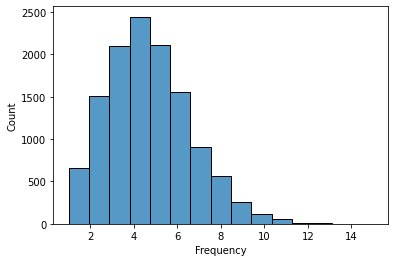

In [28]:
dF_frequency=dF_clean[["Customer Id","Order Id"]].groupby("Customer Id",as_index=False).nunique()
dF_frequency.columns=["Customer Id","Frequency"]
sns.histplot(dF_frequency.Frequency,bins=15,kde=False)

50% of our customers have ordered from us 4 times or more.

In [29]:
dF_frequency["F"],Intervals_Frequency=pd.qcut(dF_frequency["Frequency"],q=3,labels=[1,2,3],retbins=True)
Intervals_Frequency

array([ 1.,  3.,  5., 15.])

In [30]:
dF_frequency

,Customer Id,Frequency,F
0,1,1,1
1,2,4,2
2,3,5,2
3,4,4,2
4,5,3,1
...,...,...,...
12292,12431,13,3
12293,12432,9,3
12294,12433,3,1
12295,12434,6,3


**What did we do?**

After removing the values, we found out the total number of orders for each customers. We divided the frequency in 3 quantile range.

This means that first 33% of customers have their total number of purchases between 1 and 3.
The next 33 % of customers (33-66 percentile) have their total number of purchased between 3 and 5 and so on.

We assigned a score of 1 to customers having frequency between 1-3, score of 2 to customers having frequency between 3-5, and score of 3 to customer having frequency in interval 5-15.

The more the frequency, more is value generated for the store, thats why a higher score is better.

**Recency**

Recency of a customer is time since last purchase date of customer. Here the opposite will be true,lesser the recency, more responsive is customer to promotional offers.

Here we will find last purchase date for each customer and subract it from the last recorded date in the database. This is done because dataset is not recent and last date in our cleaned data is of 2017.

In a real life scenario, we will subract last purchase date from current date.

In [31]:
dF_recency=dF_clean[["Customer Id","order date (DateOrders)"]].groupby("Customer Id",as_index=False).max()
dF_recency.rename(columns ={"order date (DateOrders)":"last_purchase_date"},inplace=True)
max_date=dF_recency["last_purchase_date"].max()
dF_recency["recency"]=max_date-dF_recency["last_purchase_date"]
dF_recency["recency"]=dF_recency["recency"].dt.days

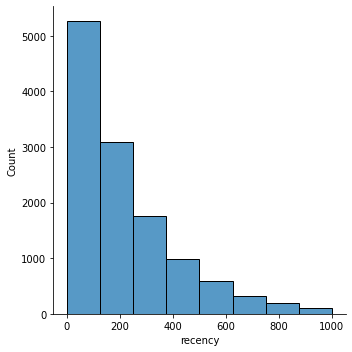

In [32]:
sns.displot(dF_recency.recency,bins=8,kde=False)

We can observe that around 5250 of our customer have purchased from us in the last three months.

In [33]:
dF_recency['R'],Intervals_Recency=pd.qcut(dF_recency["recency"],q=3,labels=[3,2,1],retbins=True)

In [34]:
print("Interval Recency:"+f"{Intervals_Recency}")

Interval Recency:[   0.   90.  242. 1003.]


Since here lesser frequency is good. Higher score will be assign when recency is less. If customer has recency in first interval of 0-90, he will get score of 3.

**Monetary**

Monetary value represents total amount of all orders of a customer. Here more is better, so higher score will be assign to higher monetary value. 

In [35]:
dF_monetory=dF_clean[["Customer Id","Order Item Total"]].groupby("Customer Id",as_index=False).sum()
dF_monetory.columns=["Customer Id","Sum_of_Sales"]
dF_monetory["M"],Intervals_Monetory=pd.qcut(dF_monetory["Sum_of_Sales"],q=3,labels=[1,2,3],retbins=True)
Intervals_Monetory

array([  24.25      , 1709.77668252, 2823.92335643, 9436.61008833])

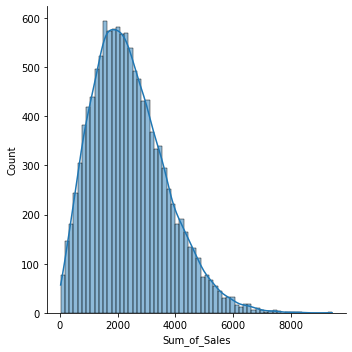

In [36]:
sns.displot(dF_monetory.Sum_of_Sales,kde=True)

We can see that Monetary value follows a normal distribution, also the average of all monetary value looks to be around 2300-2400. 

Now we will join all three values of recency, frequency, and monetary on Customer Id. We will find a combine score of RFM for each Customer Id. Then we will segment the customers based on that score.

In [37]:
dF_rfm=pd.merge(dF_recency[["Customer Id","R"]],dF_monetory[["Customer Id","M"]],on="Customer Id",how="inner")
dF_rfm=pd.merge(dF_rfm,dF_frequency[["Customer Id","F"]],on="Customer Id",how="inner")
dF_rfm["RFM"]=(dF_rfm["R"]).astype(str)+(dF_rfm["F"]).astype(str)+(dF_rfm["M"]).astype(str)

In [38]:
dF_rfm

,Customer Id,R,M,F,RFM
0,1,1,1,1,111
1,2,3,1,2,321
2,3,2,3,2,223
3,4,1,1,2,121
4,5,1,1,1,111
...,...,...,...,...,...
12292,12431,3,3,3,333
12293,12432,2,3,3,233
12294,12433,3,1,1,311
12295,12434,2,3,3,233


In [39]:
pd.set_option('display.max_colwidth', None)
Segment_Strategy=pd.read_excel("../input/rfm-segmentation-strategy/Segments_Strategy.xlsx")
Segment_Strategy

,Recency,Frequency,Monetary,Customer Segment,Strategy
0,3,3,1-2,Loyal Customers,They visit our store frequently and look to buy things at the best price. They want Quantity and Quality. Offer them Discounts and Promotional offers to retain them
1,3,3-2,3,Big Spenders,Customers in this segment will buy quality products even if they are expensive. The brand value and exclusiveness of the products matters for them. Send them promotional messages of exclusive products or when new stock arrives at the store. They visit our store often and are big spenders.
2,3,1,1-2-3,New Customers,"They are new customers who have recently visited our stores. Provide them the best service. Try to retain them by offering discounts on their next visit, taking their satisfaction surveys and providing good after sales service."
3,3,2,1-2,Bargain Customers,"They visit our store less frequently than the loyal customers. They are looking for quantity, often checking prices and benefits at different stores before making a purchase. They are most difficult customers to retain. Send them promotional messages of products where we have advantage of economics of scale."
4,1,1-2-3,3,Lost Customers-Big Spenders,They were big spenders at our store once. Now it has been some time they have consumed our services. Ask them about the reason for shift in behaviour. Improve our products/ Services in the areas they were dis-satisfied.
5,1,1-2,1-2,Lost Customers - Bargain,They were bargain customers at our store once.It has been some time they have visited our store. Ask them about their needs and see if we can offer the same products at competitive prices.
6,1-2,3,1-2,Lost/Almost Lost Customers Loyal,They were loyal customers at our store once. Strategy should be same as one for Lost Customers Big Spenders. Ask them for reasons for not visiting our store and improve in areas where we could.
7,2,2,1-2,Occasional Customers - Bargain,"They purchase from us occasionally, less frequently than loyal customers. They are looking for best value and when they find it at our store , they purchase from us. We can dive into the specifics of the purchases individually for each customer, and try to offer them similar deals on their next purchase to retain them."
8,2,2-3,3,Occasional Customers -Big Spenders,"They purchase from us occasionally, less frequently than loyal customers. They are looking for quality and exclusivity and when they find it at our store , they purchase from us. We can dive into the specifics of the purchases individually for each customer, and try to offer them similar deals on their next purchase to retain them."
9,2,1,1-2-3,Unsatisfied Customers,"They have purchased from us some time back as we were having the products they want, but their low frequency indicates that they were not happy with the experience at the stores. We can also call them reluctant buyers. Our aim should be to convert them to Loyal customers or big spenders."


In [40]:
def Customer_Segment(data):
    if data["R"]==1 and data["F"] in [1,2,3] and (data["M"]==3):
        return "Lost Customers - Big Spenders"
    elif data["R"]== 1 and data["F"] in [1,2] and data["M"] in [1,2]:
        return "Lost Customers - Bargain"
    elif data["R"] in [1,2] and data["F"]==3 and data["M"] in [1,2]:
        return "Lost/Almost Lost Customers - Loyal"
    elif (data["R"]==3) and (data["F"]==3) and data["M"] in [1,2]:
        return "Loyal Customers"
    elif (data["R"]==3) and data["F"] in [3,2] and data["M"]==3:
        return "Big Spenders"
    elif (data["R"]==3) and (data["F"]==1) and data["M"] in [1,2,3]:
        return "New Customers"
    elif (data["R"]==3) and (data["F"]==2) and data["M"] in [1,2]:
        return "Bargain Customers"
    elif (data["R"]==2) and data["F"]==2 and data["M"] in [1,2]:
        return "Occasional Customers-Bargain"
    elif (data["R"]==2) and data["F"] in [2,3] and data["M"]==3:
        return "Occasional Customers- Big Spenders"
    elif (data["R"]==2) and data["F"]==1 and data ["M"] in [1,2,3]:
        return "Unsatisfied Customers"
    else:
        return "No Segment"
    

In [41]:
dF_rfm["R"]=dF_rfm["R"].astype("category")
dF_rfm["F"]=dF_rfm["F"].astype("category")
dF_rfm["M"]=dF_rfm["M"].astype("category")
dF_rfm["Segment"]=dF_rfm.apply(Customer_Segment,axis=1)

In [42]:
Segment_count=(dF_rfm.groupby("Segment",as_index=False).agg(Total_Count=("Customer Id","count"))).sort_values(by="Total_Count",ascending=False)

In [43]:
fig2=go.Figure()
fig2.add_trace(go.Bar(x=Segment_count.Segment,
                      y=Segment_count.Total_Count,
                     hovertemplate ="%{label}<br>Number of Customers:%{value}",
                     texttemplate = "%{value}"))
fig2.update_layout(title="Number of Customer in Each Segment",
                    xaxis=dict(title="Customer Segment"),
                  yaxis=dict(title="Number Of Customers"),width=800)

In [44]:
dF_clean=pd.merge(dF_clean,dF_rfm[["Customer Id","RFM","Segment"]],on="Customer Id",how="left")
dF_segment_revenue=dF_clean.groupby("Segment",as_index=False).agg(Total_Revenue=("Order Item Total","sum")).sort_values(by="Total_Revenue",ascending=False)
fig3=go.Figure()
fig3.add_trace(go.Bar(x=dF_segment_revenue.Segment,
                      y=dF_segment_revenue.Total_Revenue,
                     hovertemplate ="%{label}<br>Revenue:%{value}",
                     texttemplate = "%{value}"))
fig3.update_layout(title="Revenue Generated by Each Segment",xaxis=dict(title="Customer Segment"),
                  yaxis=dict(title="Revenue"))

**Points To Note-**

- As we can see, the count of number of bargain customer is much higher than big spenders, but when we look at the revenue bar graph, **big spenders** are producing the most revenue. This comes to around **40% of total revenue** when we calculate it. That's why it is necessary to provide the best service to them as they contribute most to our revenue and losing them to competitor creates a serious loss to store.

- But as we can see in this chart bargain customers are also producing significant revenue, they provide the store advantage of economies of scale. 

- Another thing to notice is that **Count of Lost Customers - Bargain is much more than current Bargain Customers.** While for Big spenders opposite is true, current big spenders have much greater Count than past big spenders. This shows that **bargain customers are difficult to retain**.

- One more thing to notice here is that **revenue generated by lost customer** is also significant i.e around **27%** of total revenue. When we look at data, lost customers havent purchased from us in last 242 days or more. The store should think of strategies so they could retain more customers. The strategies should include simplifying User Interface incase of ecommerce website, faster deliveries, more payment options etc. Before deciding strategies organization could take suggestions from multiple of sources such as **focus groups, customer surveys**,etc

**Treemap**

We will prepare a treemap to find top revenue generating products in each segment.

In [45]:
def wrap(a):
    str1=a.split(" ")
    final_str=""
    for c in str1:
        final_str=final_str+c+'<br>'
    return final_str

In [46]:
Df1=dF_clean.groupby(["Segment","Department Name","Product Name"],
                     as_index=False
                    ).agg(Total_Revenue=("Order Item Total","sum"),Total_Quantity=("Order Item Quantity","sum"))
Df1["Product Name"]=Df1["Product Name"].apply(wrap) #Applying text wrap because our product names are too long
segment=["Big Spenders","Bargain Customers","Loyal Customers","New Customers"]
def type1(data):
    if "Big Spenders" in data["Segment"]:
        return "Big spenders"
    elif "Bargain" in data["Segment"]:
        return "Bargain"
    elif "Loyal" in data["Segment"]:
        return "Loyal"
    elif "New" in data["Segment"]:
        return "New Customers"
    else:
        return "Unsatisfied"
    
Df1["Customer Type"]=Df1.apply(type1,axis=1)

In [47]:
data_tm=list(Df1.groupby("Customer Type"))+[('All',Df1)]

traces=[]
buttons=[]
visible=[]
for i,d in enumerate(data_tm):
     visible=[False]*len(data_tm)
     visible[i]=True
     title=d[0]
     traces.append((px.treemap(d[1],
                               path=[px.Constant("All"),"Customer Type","Segment","Department Name","Product Name"],
                             values="Total_Revenue").update_traces(visible= True if i==0 else False)).data[0])
     buttons.append(dict(label=title,
                        method="update",
                        args=[{
                            "visible":visible},
                            {"title":f"{title}"}
                        ]))     
        
updatemenus=[{"active":0,"buttons":buttons}]
fig11=go.Figure(data=traces,layout=dict(updatemenus=updatemenus))
fig11.update_layout(title=data_tm[0][0],title_x=0.6)
fig11.update_coloraxes(colorbar_title_text="Total<br>Quantity")
fig11.show()

## ABC Analysis

ABC analysis is used for product segmentations. It is a type of supply side segmentation while RFM analysis is demand side segmentation. 

ABC analysis has its basis in the pareto rule which states that 80% of outcome comes from 20% of causes. 

Similarly here, 80% of the revenue is generated by 20% of all products. High care should be taken that these 20% of the products are always instock.

Here's how we segment product based on their revenue generating capacity.
- We find percentage of total revenue generated by each product. 
- Then we arrange them in decreasing order of percentage and we find cumulative percentage of revenue for each of the products.
    - Products generating 75% of revenue would be Class A products
    - Procucts generating next 20% of revenue would be class B products. Products having their cumulative percentage between 75%-95%.
    - Products generating remaining 5% of revenue would be class C products. Long list of products each contribuling very less to total revenue. Also called as long tail. They have their cumulative percentage between 95%-100%


In [48]:
Total_Products=dF_clean["Product Name"].nunique()
print("Total Number of products: "+f"{Total_Products}")

Total Number of products: 100


In [49]:
Revenue_ABC=dF_clean.groupby(["Department Name","Product Name"]).agg(Total_Revenue=("Order Item Total","sum")).sort_values(by="Total_Revenue",ascending=False).reset_index()
Revenue_ABC["cum_sum"]=Revenue_ABC["Total_Revenue"].cumsum()
Revenue_ABC["cum_per"]=Revenue_ABC["cum_sum"]/Revenue_ABC["Total_Revenue"].sum()*100
Revenue_ABC["per"]=Revenue_ABC["cum_per"]-Revenue_ABC["cum_per"].shift(1)
Revenue_ABC.loc[0,"per"]=Revenue_ABC["cum_per"][0]

In [50]:
def ABC(data):
    if data["cum_per"]<=75:
        return "A"
    elif data["cum_per"]>75 and data["cum_per"]<=95:
        return "B"
    elif data["cum_per"]>95:
        return "C"

Revenue_ABC["ABC_Revenue"]=Revenue_ABC.apply(ABC,axis=1)

In [51]:
Bar_graph_Abc=Revenue_ABC[["ABC_Revenue","Product Name","Total_Revenue"]].groupby("ABC_Revenue").agg(Revenue=("Total_Revenue","sum"),count=("Product Name","count"))

In [52]:
Bar_graph_Abc
fig2=go.Figure(go.Bar(x=Bar_graph_Abc.index,
                      y=Bar_graph_Abc["Revenue"],
                     hovertemplate ="%{label}<br>Revenue:%{value}",
                     texttemplate = "Revenue<br>%{value}",
                     marker_color=["orange","lightgreen","red"],
                     showlegend=False))
fig2.add_trace(                          
    go.Scatter(                          
    x=Bar_graph_Abc.index,
    y=Bar_graph_Abc["count"],
    name="Number Of Products",
    mode='lines',                                                       
    line = dict(color='blue', width=3),   
    yaxis="y2",
    marker_line_width = 0
    ))

fig2.update_layout(
                   title="Revenue Generated By Products in Different ABC Segments",
                   xaxis=dict(title="Segment" ),
                   yaxis=dict(title="Revenue",showgrid=False),
                   yaxis2=dict(title="Number Of Products", anchor="x", overlaying="y",side="right",dtick=10),
                   legend = dict(x = 1.05, y = 1))
fig2.show()

**Inference**-
- As we can see just **6 products contribute to 75% of our revenue**. They are critical for our store, and we should provide high service level for them. We should have safety stock for them and **never be out of stock** for these products.

- In this case, the ratio is even starker than pareto hypothesis. Only 6% of products are generating 75% of revenue. And just 11% of products generating 95% of revenue. So now its become more important for store to keep inventory of these products.

- We should find **multiple suppliers for A class products**, incase there is shortage of products at one supplier. Since they are driving our revenue, not having these products in stock even for one day would result in considerable revenue loss for the organization and it will also drive our customers to competitors.Research shows that **37% of customer will head to competitor stores for the product they couldn't buy at one store**.

- **B category products** here contribute to around 20% of revenue. They are also important to our business. Since there are only **5 products** in this case which are in B category, they are more important to our business than usual B category. Becuase ideally number of individual products in B category are more than the number of products in A category. We should have them in stock, and have a **procedure in place to order them**. 

- Maximum proportion of money and stocking space should go to class A products. After that class B products should  be allocated money and stocking space afterwards. Inventory of **class C products should be minimum** as they generate the least revenue. There are 89 products in Class C and if we have inventory of such products more than its needed, **a lot of stocking space will be utilized also lot of capital will get blocked**.

ABC analysis is just one of many reports you should consider when analyzing inventory performance. While ABC analysis is valuable for seeing which products account for the greatest percentage of store revenue, you also want to look at metrics like your inventory turnover rate, days on hand, stock to sales ratio, sell through rate, rate of return, and profit margin.

### ABC Analysis Store/City/Region Wise.

_**Will do ABC Analysis for each of our top 6 Cities(Order City). This is neccessary as customer preferences change according to regions and we need to priortize different products in our inventory according to market.**_ 

In [53]:
Top6Cities=dF_clean[["Order City","Order Item Total"]].groupby("Order City").sum().sort_values(by="Order Item Total",ascending=False).head(6)

In [54]:
data=dF_clean[dF_clean["Order City"].isin(Top6Cities.index.tolist())].groupby(["Order City","Product Name"],as_index=False).agg(Total_Revenue=("Order Item Total","sum")).sort_values(by=["Order City","Total_Revenue"],ascending=False)
data["sum"]=data.groupby("Order City")["Total_Revenue"].transform('sum')
data["cum_per"]=data.groupby("Order City")["Total_Revenue"].cumsum()/data["sum"]*100
data["segment"]=data.apply(ABC,axis=1)
data["Product Name"]=data["Product Name"].apply(wrap)
data.sort_values(by=["sum","Total_Revenue"],inplace=True,ascending=False)

In [55]:
fig = px.bar(data[data["segment"]=="A"], x='Product Name', y='Total_Revenue',
             facet_col='Order City',facet_col_wrap=2,facet_row_spacing=0.12,
             height=1500,title="A Segment Products in Top 6 Cities")
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))
fig.update_xaxes(showticklabels=True,tickangle=0)
fig.update_layout(width=950)
fig.show()

We can note here that in some city A class products differ from others. For. eg Pelican Sunstream 100 Kayak is not an Class A Product in Managua and New york, while Nike Men Drifit Victory Golf polo is not an class A product in Los Angles. So while managing inventory for these cities we could invest a little less capital and stocking space for these products. 